Step 1: Setup and Enviroment

In [1]:

print("--- Step 1: Setting up the environment ---")

# Install necessary libraries quietly
!pip install kagglehub transformers datasets scikit-learn accelerate torch -q

import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive, userdata
from PIL import Image
from torch.utils.data import Dataset
from transformers import SegformerForImageClassification, SegformerImageProcessor, Trainer
from sklearn.metrics import confusion_matrix, classification_report
import kagglehub
import glob

os.environ["WANDB_DISABLED"] = "true"

# Mount your Google Drive to access the saved model
print("\n--- Mounting Google Drive ---")
drive.mount('/content/drive')

# Authenticate with Kaggle to download the test dataset
print("\n--- Authenticating with Kaggle ---")
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

# Define the device to use (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

--- Step 1: Setting up the environment ---

--- Mounting Google Drive ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

--- Authenticating with Kaggle ---

Using device: cuda


Step 2: Locate Your Trained Model

In [2]:

print("\n--- Step 2: Select your trained model from Google Drive ---")

# The base directory where your models are saved
base_drive_path = "/content/drive/MyDrive"

try:
    # Get a list of all items in the base directory and filter for folders only
    all_folders = [f for f in os.listdir(base_drive_path) if os.path.isdir(os.path.join(base_drive_path, f))]

    # We assume model folders contain a 'config.json' file, so we filter for those
    model_folders = [f for f in all_folders if 'config.json' in os.listdir(os.path.join(base_drive_path, f))]

    if not model_folders:
        print("❌ ERROR: No trained model folders found in your Google Drive.")
        print("A valid model folder should contain a 'config.json' file.")
        # This will stop the execution if no models are found
        raise FileNotFoundError("No valid model folders found.")

    # --- Interactive Selection ---
    print("Please choose the model folder you want to test:")
    for i, folder_name in enumerate(model_folders):
        print(f"  [{i+1}] {folder_name}")

    selected_index = -1
    while selected_index < 1 or selected_index > len(model_folders):
        try:
            choice = input(f"\nEnter the number of the model folder (1-{len(model_folders)}): ")
            selected_index = int(choice)
            if not (1 <= selected_index <= len(model_folders)):
                print("Invalid number. Please try again.")
        except ValueError:
            print("Invalid input. Please enter a number.")

    # Get the folder name based on the user's choice (adjusting for 0-based index)
    selected_folder_name = model_folders[selected_index - 1]

    # Construct the final, full path to the model
    MODEL_PATH_IN_DRIVE = os.path.join(base_drive_path, selected_folder_name)
    print(f"\n✅ You have selected: '{selected_folder_name}'")
    print(f"Model will be loaded from: {MODEL_PATH_IN_DRIVE}")

except FileNotFoundError as e:
    print(f"\nAn error occurred: {e}")
    print("Please make sure your Google Drive is mounted and the model folder is in '/content/drive/MyDrive/'.")


--- Step 2: Select your trained model from Google Drive ---
Please choose the model folder you want to test:
  [1] segformer-brain-tumor-finetuned
  [2] Segformer-Brain-Tumor Model

Enter the number of the model folder (1-2): 2

✅ You have selected: 'Segformer-Brain-Tumor Model'
Model will be loaded from: /content/drive/MyDrive/Segformer-Brain-Tumor Model


Step 3: Load the Test Dataset from Kaggle

In [3]:
print("\n--- Step 3: Loading the test dataset ---")

# Download the dataset to get a clean copy
dataset_path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

# IMPORTANT: We will ONLY use the 'Testing' folder for a true evaluation
test_dir = os.path.join(dataset_path, "Testing")

# Find all image paths and their labels from the testing folder
test_paths = list(glob.glob(os.path.join(test_dir, "*", "*.jpg")))
test_labels = [os.path.basename(os.path.dirname(p)) for p in test_paths]

print(f"Found {len(test_paths)} images in the 'Testing' folder for final evaluation.")


--- Step 3: Loading the test dataset ---
Found 1311 images in the 'Testing' folder for final evaluation.


Step 4: Load Model and Prepare Test Data

In [4]:

print("\n--- Step 4: Loading your fine-tuned model and preparing the test data ---")

# Load the model from the path you provided. The library handles loading all necessary files.
model = SegformerForImageClassification.from_pretrained(MODEL_PATH_IN_DRIVE)
model.to(device) # Move the model to the GPU
model.eval()     # Set the model to evaluation mode

# Load the image processor that was saved with the model to ensure transformations are identical
image_processor = SegformerImageProcessor.from_pretrained(MODEL_PATH_IN_DRIVE)

# Get the label mappings that were saved in the model's configuration
label2id = model.config.label2id
class_names = list(label2id.keys())
print(f"Model loaded successfully. Class names: {class_names}")

# Create a custom dataset class for the test data
class TestDataset(Dataset):
    def __init__(self, image_paths, labels, image_processor):
        self.image_paths = image_paths
        self.labels = labels
        self.image_processor = image_processor

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label_id = label2id[self.labels[idx]]
        pixel_values = self.image_processor(image, return_tensors="pt").pixel_values.squeeze()
        return {"pixel_values": pixel_values, "labels": torch.tensor(label_id)}

# Create the final test dataset instance
test_dataset = TestDataset(test_paths, test_labels, image_processor)
print(f"\nTest dataset created with {len(test_dataset)} samples.")


--- Step 4: Loading your fine-tuned model and preparing the test data ---
Model loaded successfully. Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']

Test dataset created with 1311 samples.


Step 5: Run Evaluation and Visualize Results

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



--- Step 5: Starting Final Evaluation ---
Generating predictions on the test set...



📊 CLASSIFICATION REPORT 📊
              precision    recall  f1-score   support

      glioma       0.99      0.98      0.98       300
  meningioma       0.96      0.97      0.97       306
     notumor       0.99      1.00      0.99       405
   pituitary       0.99      0.99      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311


🖼️ CONFUSION MATRIX VISUALIZATION 🖼️


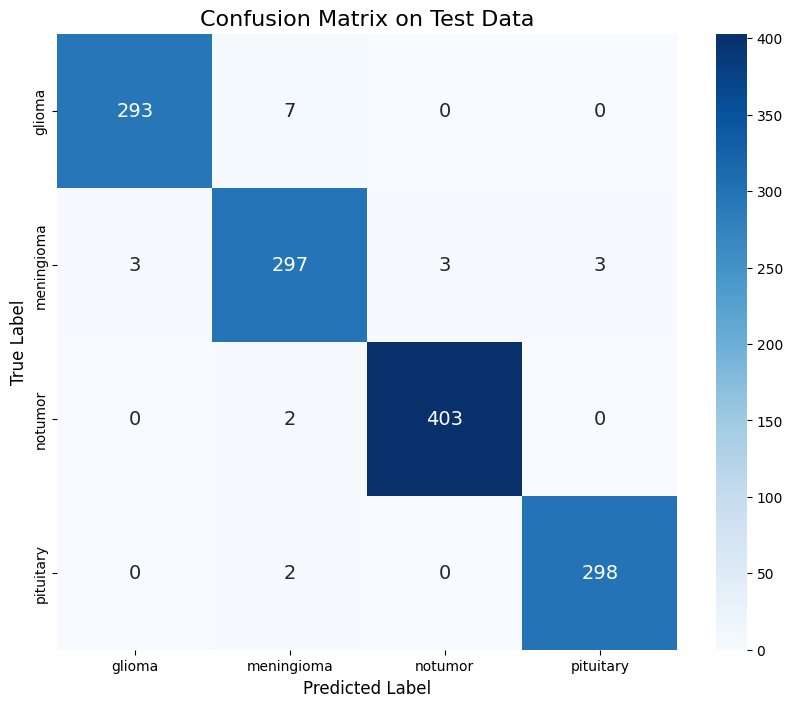

In [5]:

print("\n--- Step 5: Starting Final Evaluation ---")

# Create a basic Trainer instance just for making predictions
trainer = Trainer(model=model)

# Get model predictions on the test dataset
print("Generating predictions on the test set...")
predictions_output = trainer.predict(test_dataset)

# The actual predictions are logits, so we take the argmax to get the predicted class
predicted_labels = np.argmax(predictions_output.predictions, axis=1)
true_labels = predictions_output.label_ids

# --- Calculate and Display Accuracy Metrics ---
print("\n📊 CLASSIFICATION REPORT 📊")
# This report gives you precision, recall, f1-score, and accuracy for each class
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print(report)

# --- Visualize the Confusion Matrix ---
print("\n🖼️ CONFUSION MATRIX VISUALIZATION 🖼️")
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 14})
plt.title('Confusion Matrix on Test Data', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()